## Fashion MNIST with Convolutional Neural Networks

### Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Helper function to load data from web

In [2]:
def loadFromURL(path, offset):
  
  import gzip
  import urllib   
  import io

  request = urllib.request.urlopen(path)
  rbuf = io.BytesIO(request.read())
  f = gzip.GzipFile(fileobj=rbuf)
  data = f.read()

  return np.frombuffer(data, dtype=np.uint8, offset=offset)


def loadMNIST(path, kind='train'):
  
  import os   
  
  labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
  images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)
  labels = loadFromURL(labels_path,8)
  data = loadFromURL(images_path,16)
  return data.reshape(len(labels), 784), labels


### Load Data

In [3]:
X_train, y_train = loadMNIST('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/', kind='train')
X_test,  y_test  = loadMNIST('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/', kind='t10k')

### Tensorflow graph reset function

To make this notebook's output stable across multiple runs.

In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Sample Convolutional Kernels - horizontal and vertical lines

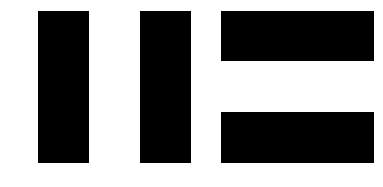

In [5]:
fmap = np.zeros(shape=(3, 3, 1, 2), dtype=np.float32)
fmap[:, 1, 0, 0] = 1
fmap[1, :, 0, 1] = 1

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(fmap[:, :, 0, 0], cmap="gray"); axarr[0].axis("off")
axarr[1].imshow(fmap[:, :, 0, 1], cmap="gray"); axarr[1].axis("off")
plt.show()

### Simple convolutions

Let's try building a convolution using the two predefined kernels above, and then running a single datapoint through it.

In [6]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
feature_maps = tf.constant(fmap)
conv1 = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

### Setup inputs

In [7]:
images = X_train[12,:].reshape(1,28,28,1)

#### Run Graph

In [8]:
with tf.Session() as sess:
    output = sess.run(conv1, feed_dict={X: images})

### Show output

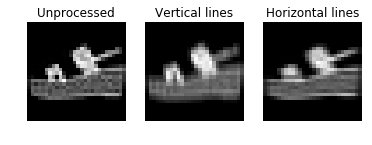

In [9]:
fig, axarr = plt.subplots(1, 3)
axarr[0].imshow(images[0, :, :, 0], cmap="gray"); axarr[0].axis("off"); axarr[0].set_title("Unprocessed")
axarr[1].imshow(output[0, :, :, 0], cmap="gray"); axarr[1].axis("off"); axarr[1].set_title("Vertical lines")
axarr[2].imshow(output[0, :, :, 1], cmap="gray"); axarr[2].axis("off"); axarr[2].set_title("Horizontal lines")
plt.show()

## Construct the network

In [10]:
reset_graph()

### Input Layer

Now let's start building the neural network. First we will create the input layer:

In [11]:
with tf.name_scope("input_layer"):
    X_batch = X_train.reshape(X_train.shape[0],28,28,1)[0:50,:,:,:] # take first 50 datapoints for now
    batch_size, height, width, channels = X_batch.shape
    X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32, name="inputs")

### Primary Convolutional Layer

Next we will create the primary convolutional layer which will connect to the input layer.

In [12]:
with tf.name_scope("convolutional_layers"):
    conv1 = tf.layers.conv2d(X, filters=32, kernel_size=3, strides=[1,1], padding="SAME", name="conv1")

View the outputs of convolutional layer 1

### Secondary Convolutional Layer

In [13]:
with tf.name_scope("convolutional_layers"):
    conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=3, strides=[2,2], padding="SAME", name="conv2")

### Pooling Layer

We'll use a max pooling layer with 2x2 kernel size after the two convolutional layers.

In [14]:
with tf.name_scope("pooling_layers"):
    max_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME", name="pool1")    
    max_pool_flat = tf.reshape(max_pool, shape=[-1, 64 * 7 * 7], name="pool1_flat")

### Fully connected layer

Now let's add a fully connected layer to the max pooling layer.

In [15]:
with tf.name_scope("fully_connected"):
    fc1 = tf.layers.dense(max_pool_flat, 64, activation=tf.nn.relu, name="fc1")

### Output layer

And finally an output layer with 10 outputs. We will also add a softmax on the outputs to get some estimated class probabilities.

In [16]:
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, 10, name="logits")
    Y_probs = tf.nn.softmax(logits, name="Y_probs")

## Run the untrained network

At this stage we should run the model in it's untrained state to make sure that the ouputs from each layer look reasonable.

In [17]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    inputs_outputs, conv1_output, conv2_output, pool_output, pool_output_flat, logits_out, Y_probs_out = sess.run(
        [X, conv1, conv2, max_pool, max_pool_flat, logits, Y_probs],
        feed_dict={X: X_batch}
    )
    conv1_kernels = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES , 'conv1/kernel')[0]    
    conv2_kernels = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES , 'conv2/kernel')[0]
    conv1_kernels_np = conv1_kernels.eval()
    conv2_kernels_np = conv2_kernels.eval()

In [18]:
# Helper function to plot outputs
def plot_data_point(dp, ax, title):
    ax.imshow(dp, cmap="gray")
    ax.axis("off")
    ax.set_title(title)    

Track some randomly selected data points through the various layers up to max pooling:

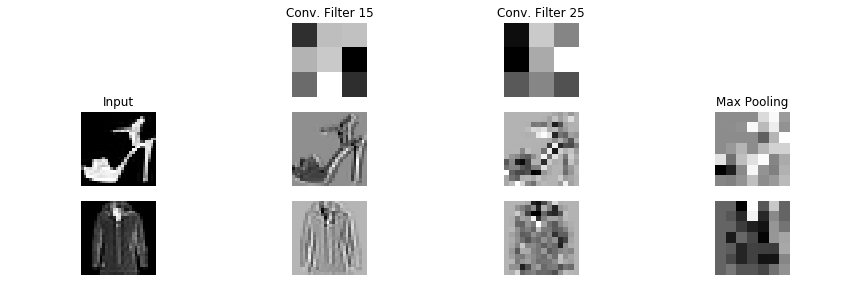

In [19]:
fig, axarr = plt.subplots(3,4)

# plot filters
axarr[0,0].axis("off")
plot_data_point(conv1_kernels_np[:,:,0,14], axarr[0,1], "Conv. Filter 15")
plot_data_point(conv2_kernels_np[:,:,0,24], axarr[0,2], "Conv. Filter 25")
axarr[0,3].axis("off")

# plot data point 10
plot_data_point(inputs_outputs[9, :, :, 0], axarr[1,0], "Input")
plot_data_point(conv1_output[9, :, :, 14], axarr[1,1], "")
plot_data_point(conv2_output[9, :, :, 24], axarr[1,2], "")
plot_data_point(pool_output[9, :, :, 49], axarr[1,3], "Max Pooling")

# plot data point 20
plot_data_point(inputs_outputs[19, :, :, 0], axarr[2,0], "")
plot_data_point(conv1_output[19, :, :, 14], axarr[2,1], "")
plot_data_point(conv2_output[19, :, :, 24], axarr[2,2], "")
plot_data_point(pool_output[19, :, :, 49], axarr[2,3], "")

plt.subplots_adjust(right=2, top=1)
plt.show()

As expected, the images get more distorted with each layer, and there is a loss of resolution after conv2 (because of the stride 2 length) and after max pooling.

We can also check the output dimensions are correct:

In [20]:
print(inputs_outputs.shape);
print(conv1_output.shape);
print(conv2_output.shape);
print(pool_output.shape);
print(pool_output_flat.shape);
print(logits_out.shape);
print(Y_probs_out.shape);

(50, 28, 28, 1)
(50, 28, 28, 32)
(50, 14, 14, 64)
(50, 7, 7, 64)
(50, 3136)
(50, 10)
(50, 10)


## Train the network

Now we need to train the network. Firstly, pull in the ground truth labels:

In [21]:
with tf.name_scope("inputs"):
    y = tf.placeholder(tf.int32, shape=[None], name="y")

Next, define the training function:

In [22]:
with tf.name_scope("train"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss_function = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss_function)

And the evaluation function:

In [23]:
with tf.name_scope("evaluation"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Now let's train the model!

In [24]:
n_epochs = 30
batch_size = 1000

# helper function to get batches of training data
def get_batch(X, y, iteration):
    start = iteration * batch_size; end = min((iteration + 1) * batch_size - 1, X.shape[0] - 1)
    X_batch = X[start:end,:].reshape(-1,28,28,1)
    y_batch = y[start:end]
    return X_batch, y_batch    

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    # Show train/test error befor training starts
    X_batch, y_batch = get_batch(X_train, y_train, 0)
    acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
    acc_test = accuracy.eval(feed_dict={X: X_test.reshape(-1,28,28,1), y: y_test})
    print("Epoch:", 0, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    
    # now start training
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            start = iteration * batch_size; end = min((iteration + 1) * batch_size -1, X_train.shape[0] - 1)
            X_batch, y_batch = get_batch(X_train, y_train, iteration)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test.reshape(-1,28,28,1), y: y_test})
        print("Epoch:", epoch + 1, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    
    # store convolutional kernel weights
    conv1_kernels = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES , 'conv1/kernel')[0]    
    conv2_kernels = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES , 'conv2/kernel')[0]
    conv1_kernels_np = conv1_kernels.eval()
    conv2_kernels_np = conv2_kernels.eval()

Epoch: 0 Train accuracy: 0.11111111 Test accuracy: 0.1086
Epoch: 1 Train accuracy: 0.7687688 Test accuracy: 0.7565


### Plot the same filters datapoints in the trained model

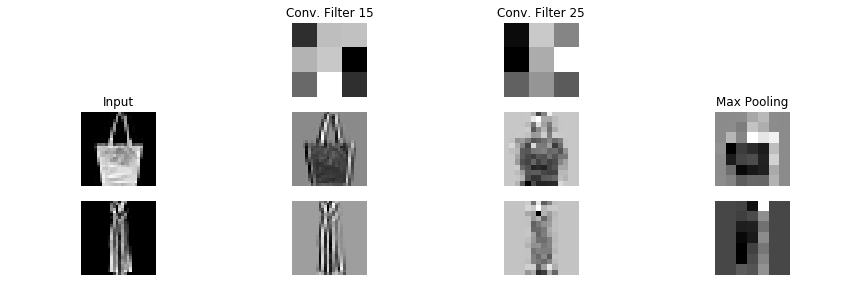

In [24]:
fig, axarr = plt.subplots(3,4)

# plot filters
axarr[0,0].axis("off")
plot_data_point(conv1_kernels_np[:,:,0,14], axarr[0,1], "Conv. Filter 15")
plot_data_point(conv2_kernels_np[:,:,0,24], axarr[0,2], "Conv. Filter 25")
axarr[0,3].axis("off")

# plot data point 10
plot_data_point(inputs_outputs[9, :, :, 0], axarr[1,0], "Input")
plot_data_point(conv1_output[9, :, :, 14], axarr[1,1], "")
plot_data_point(conv2_output[9, :, :, 24], axarr[1,2], "")
plot_data_point(pool_output[9, :, :, 49], axarr[1,3], "Max Pooling")

# plot data point 20
plot_data_point(inputs_outputs[19, :, :, 0], axarr[2,0], "")
plot_data_point(conv1_output[19, :, :, 14], axarr[2,1], "")
plot_data_point(conv2_output[19, :, :, 24], axarr[2,2], "")
plot_data_point(pool_output[19, :, :, 49], axarr[2,3], "")

plt.subplots_adjust(right=2, top=1)
plt.show()

### What if we flip the inputs upside-down??

In [25]:
def flip(X_in):
    X_out = np.zeros(shape=X_in.shape, dtype=np.int64)
    rows = X_in.shape[0]; cols = X_in.shape[1]
    for i in range(0, rows):
        for j in range(0,cols,28):
            k = cols - j
            X_out[i,j:j+28] = X_in[i,k-28:k]
    return X_out

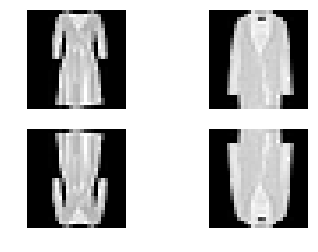

In [26]:
X_test_flipped = flip(X_test)

fig, axarr = plt.subplots(2,2)

plot_data_point(X_test[10,:].reshape(28,28), axarr[0,0],"")
plot_data_point(X_test[20,:].reshape(28,28), axarr[0,1],"")
plot_data_point(X_test_flipped[10,:].reshape(28,28), axarr[1,0],"")
plot_data_point(X_test_flipped[20,:].reshape(28,28), axarr[1,1],"")

In [28]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    acc_test = accuracy.eval(feed_dict={X: X_test_flipped.reshape(-1,28,28,1), y: y_test})
    print("Test accuracy on flipped data:", acc_test)

Test accuracy on flipped data: 0.1272
